In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from SNNP import io
from SNNP import PotentialNN

# load the data

The data come from https://github.com/libAtoms/silicon-testing-framework/tree/master/models/GAP which used for the GAP.

In [2]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "data", "silicon.xyz")

In [3]:
data_reader = io.DataReader()
data_reader.dataframe_from_trajectory(data_filename, prefix='dft')

In [4]:
df_data = data_reader.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 2474
Number of forces: 515442


```structure_summary``` is a function in ```PotentialNN``` that tells what configurations and sizes do the data have

In [5]:
PotentialNN.structure_summary(df_data)

,config_type,data_size,size
0,sh,223,"[1.0, 8.0, 27.0, 64.0]"
1,dia,489,"[2.0, 16.0, 54.0, 128.0]"
2,bt,445,"[2.0, 16.0, 54.0, 128.0]"
3,liq,76,"[64.0, 128.0]"
4,amorph,159,"[64.0, 216.0]"
5,surface_001,29,[144.0]
6,surface_110,26,[108.0]
7,surface_111,47,[96.0]
8,surface_111_pandey,50,[96.0]
9,crack_110_1-10,7,[200.0]


# Featurization of the data

```featurization``` is a class that transform the xyz file to a input for a neural network. After ```data_from_dataframe```, the geometries and forces of dataframe will be loaded as pairwise distance for each structure and $F = \sqrt{F^2_x + F^2_y + F^2_z}$ for each atom. 

I used three radial Behler-Parrinello symmetry functions. The corresponding functions are given by:

\begin{equation}
G^{(i)}_1(\textbf{r}) = \Sigma_{j \neq i} f_c(\textbf{r}_{ij})
\end{equation}

\begin{equation}
G^{(i)}_2(\textbf{r}) = \Sigma_{j \neq i} e^{-\eta(|\textbf{r}_{ij}|-Rs)^2}f_c(\textbf{r}_{ij})
\end{equation}

\begin{equation}
G^{(i)}_3(\textbf{r}) = \Sigma_{j \neq i} cos(\kappa|\textbf{r}_{ij}|)f_c(\textbf{r}_{ij})
\end{equation}

where $f_c(\textbf{r}_{ij})$ is the cutoff function.

In [6]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

In ```input_descriptor```, we can choose to use pairwise distance or symmetry function. Also, the parameter of the symmetry function can be customized. Here will demonstrate using symmetry function, force and configuration type as the input for the neural network. Later will demonstrate the results with different inputs.

The parameters used for the symmetry are chosen by trial and error only. There is an automatic selection for symmetry function parameters (https://aip.scitation.org/doi/full/10.1063/1.5024611) but I haven't add this in this package yet. I will update later.

Here I assumed that the ```Y```, energy per atom in a molecule, is just the average of the total energy (i.e $E_i = E/n$), where is the size of the molecule) which is not very appropriate, I am trying to find a better way to do it

In [7]:
%%time
X, Y = feat.input_descriptor(rmin = 2.6, rmax = 6, Rs = [1,2,3], eta = [2, 10, 100], kappa = [2.5, 8.5],
                             force = True,
                             config_type = True)

CPU times: user 3min 33s, sys: 1.5 s, total: 3min 34s
Wall time: 1min 1s


```input_dimension``` shows that the input contains 12 G values, 1 force, and 1 configuration type number.

In [8]:
feat.input_dimension

14

# Neuarl network

Sci-kit learn framework is used for the neural network. The ```neural_network``` allows us to split the data, save the nn model, print and plot all the results. 

Prediction of energy per atom: 

R2 score =  0.92448

MSE test  =  0.00398     MAE test  =  0.04032

MSE train =  0.00361     MAE train =  0.03976



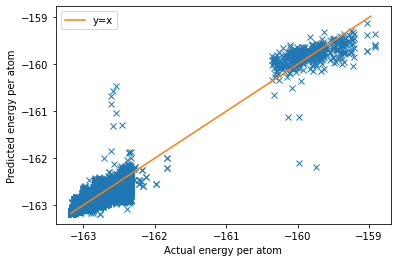

Prediction of total energy: 

R2 score =  1.00000

MSE test  = 16.71919     MAE test  =  2.20609

MSE train = 17.10438     MAE train =  2.27979



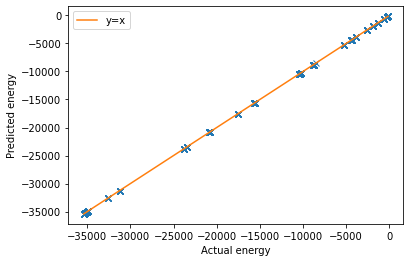

CPU times: user 13min 29s, sys: 24.1 s, total: 13min 54s
Wall time: 3min 31s


In [9]:
%%time
nn = PotentialNN.neural_network(train_size = 0.2, layer_sizes = (30,30), 
                                random_state = 0, total_energy = True)

nn.split(X, Y, filename = 'silicon_training_index{}')

nn.fit(filename = 'nn_silicon.pickle')

errors_per_atom, errors_total_energy = nn.predict()

# Different descriptor

## using pairwise distance with force, configuration types and sizes

In [10]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

In [11]:
%%time
X, Y = feat.input_descriptor(symmetry_para = False,
                             force = True,
                             config_type = True, size = True)

CPU times: user 429 ms, sys: 232 ms, total: 661 ms
Wall time: 681 ms


Prediction of total energy: 

R2 score =  0.98477

MSE test  = 2446341.99365     MAE test  = 983.74103

MSE train = 2377958.68822     MAE train = 974.89657



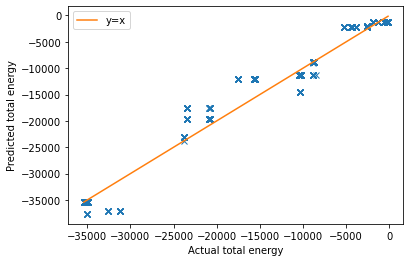

ValueError: too many values to unpack (expected 2)

In [12]:
%%time
nn = PotentialNN.neural_network(train_size = 0.8, layer_sizes = (200,200), 
                                random_state = 0, symmetry_para = False)

nn.split(X, Y, filename = None)

nn.fit(filename = None)

errors = nn.predict()

## only symmetry function

In [13]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

In [14]:
%%time
X, Y = feat.input_descriptor(rmin = 2.6, rmax = 6, Rs = [1,2,3], eta = [2, 10, 100], kappa = [2.5, 8.5],
                             force = False,
                             config_type = False)

CPU times: user 3min 43s, sys: 1.46 s, total: 3min 45s
Wall time: 1min 4s


Prediction of energy per atom: 

R2 score =  0.75024

MSE test  =  0.01316     MAE test  =  0.07784

MSE train =  0.01314     MAE train =  0.07770



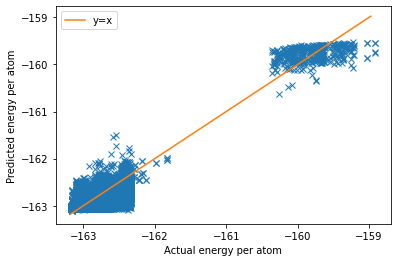

Prediction of total energy: 

R2 score =  1.00000

MSE test  = 72.77069     MAE test  =  4.54823

MSE train = 77.91670     MAE train =  4.89436



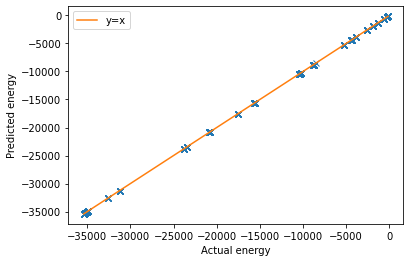

CPU times: user 2min 25s, sys: 2.81 s, total: 2min 28s
Wall time: 38 s


In [15]:
%%time
nn = PotentialNN.neural_network(train_size = 0.2, layer_sizes = (30,30), 
                                random_state = 0, total_energy = True)

nn.split(X, Y, filename = None)

nn.fit(filename = None)

errors_per_atom, errors_total_energy = nn.predict()

## symmetry function and force

In [16]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

In [17]:
%%time
X, Y = feat.input_descriptor(rmin = 2.6, rmax = 6, Rs = [1,2,3], eta = [2, 10, 100], kappa = [2.5, 8.5],
                             force = True,
                             config_type = False)

CPU times: user 3min 33s, sys: 861 ms, total: 3min 34s
Wall time: 1min 1s


Prediction of energy per atom: 

R2 score =  0.75696

MSE test  =  0.01281     MAE test  =  0.07736

MSE train =  0.01262     MAE train =  0.07700



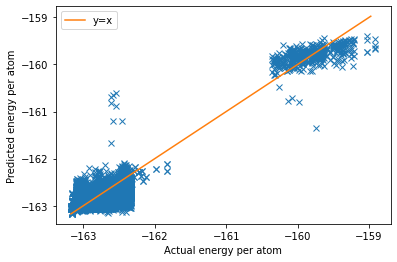

Prediction of total energy: 

R2 score =  1.00000

MSE test  = 69.95723     MAE test  =  4.46166

MSE train = 76.22687     MAE train =  4.82830



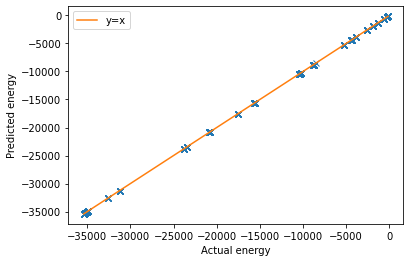

CPU times: user 3min 22s, sys: 5.45 s, total: 3min 28s
Wall time: 53.4 s


In [18]:
%%time
nn = PotentialNN.neural_network(train_size = 0.2, layer_sizes = (30,30), 
                                random_state = 0, total_energy = True)

nn.split(X, Y, filename = None)

nn.fit(filename = None)

errors_per_atom, errors_total_energy = nn.predict()

## symmetry function, force, configuration type and sizes

The original idea is including the configuration type and size so that we can predict the energy even with many configuration types and sizes. But when size is included in the descriptor, the R2 score is a bit lower.

In [19]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

In [20]:
%%time
X, Y = feat.input_descriptor(rmin = 2.6, rmax = 6, Rs = [1,2,3], eta = [2, 10, 100], kappa = [2.5, 8.5],
                             force = True,
                             config_type = True, 
                             size = True)

CPU times: user 3min 56s, sys: 2.16 s, total: 3min 58s
Wall time: 1min 9s


Prediction of energy per atom: 

R2 score =  0.91535

MSE test  =  0.00446     MAE test  =  0.04242

MSE train =  0.00417     MAE train =  0.04199



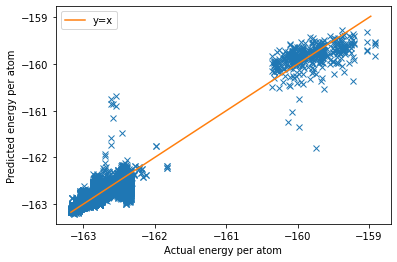

Prediction of total energy: 

R2 score =  1.00000

MSE test  = 27.05368     MAE test  =  2.45079

MSE train = 27.08119     MAE train =  2.66560



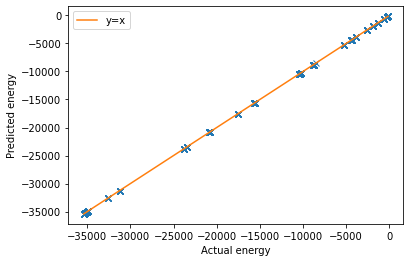

CPU times: user 5min 30s, sys: 10.2 s, total: 5min 41s
Wall time: 1min 28s


In [21]:
%%time
nn = PotentialNN.neural_network(train_size = 0.2, layer_sizes = (30,30), 
                                random_state = 0, total_energy = True)

nn.split(X, Y, filename = None)

nn.fit(filename = None)

errors_per_atom, errors_total_energy = nn.predict()

# hyper-parameter for the neural network

In [22]:
layer_sizes = [(5,5), (14,14), (30,30), (60, 60), (100, 100)]
train_sizes = np.arange(0.1, 0.9, 0.1)

In [23]:
feat = PotentialNN.featurization()
feat.data_from_dataframe(df_data)

X, Y = feat.input_descriptor(rmin = 2.6, rmax = 6, Rs = [1,2,3], eta = [2, 10, 100], kappa = [2.5, 8.5],
                             force = True,
                             config_type = True)

## different layer sizes

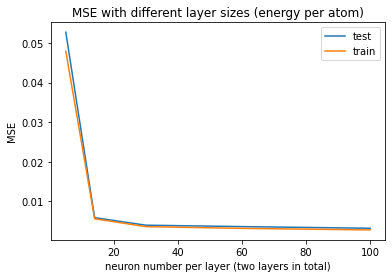

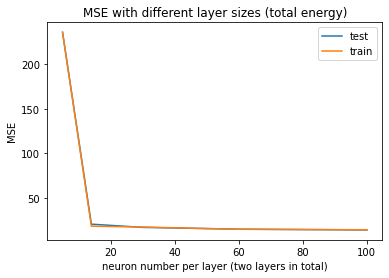

In [24]:
MSE_test_1 = []
MSE_train_1 = []
MSE_test_2 = []
MSE_train_2 = []

for layer_size in layer_sizes:
    nn = PotentialNN.neural_network(layer_sizes = layer_size, random_state = 0)

    nn.split(X, Y, filename = None)

    nn.fit(filename = None)

    e1, e2 = nn.predict(Print = False, Plot = False)

    MSE_test_1.append(e1[1])
    MSE_train_1.append(e1[2])
    MSE_test_2.append(e2[1])
    MSE_train_2.append(e2[2])

layer_sizes = [5, 14, 30, 60, 100]
plt.figure()
plt.title('MSE with different layer sizes (energy per atom)')
plt.plot(layer_sizes, MSE_test_1, label = 'test')
plt.plot(layer_sizes, MSE_train_1, label = 'train')
plt.xlabel('neuron number per layer (two layers in total)')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.title('MSE with different layer sizes (total energy)')
plt.plot(layer_sizes, MSE_test_2, label = 'test')
plt.plot(layer_sizes, MSE_train_2, label = 'train')
plt.xlabel('neuron number per layer (two layers in total)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Learning curve

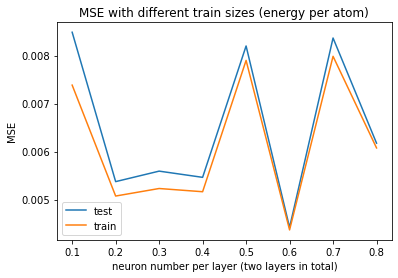

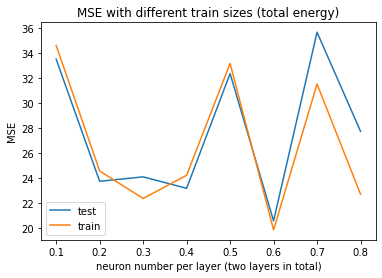

In [25]:
MSE_test_1 = []
MSE_train_1 = []
MSE_test_2 = []
MSE_train_2 = []

for train_size in train_sizes:
    nn = PotentialNN.neural_network(train_size = train_size, random_state = 0)

    nn.split(X, Y, filename = None)

    nn.fit(filename = None)

    e1, e2 = nn.predict(Print = False, Plot = False)

    MSE_test_1.append(e1[1])
    MSE_train_1.append(e1[2])
    MSE_test_2.append(e2[1])
    MSE_train_2.append(e2[2])

plt.figure()
plt.title('MSE with different train sizes (energy per atom)')
plt.plot(train_sizes, MSE_test_1, label = 'test')
plt.plot(train_sizes, MSE_train_1, label = 'train')
plt.xlabel('neuron number per layer (two layers in total)')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.title('MSE with different train sizes (total energy)')
plt.plot(train_sizes, MSE_test_2, label = 'test')
plt.plot(train_sizes, MSE_train_2, label = 'train')
plt.xlabel('neuron number per layer (two layers in total)')
plt.ylabel('MSE')
plt.legend()
plt.show()